In [ ]:
import random
import tensorflow as tf
import pandas as pd
# set the random seed:
from utils.Constants import Constants
from utils.Utils import Utils
import numpy as np
import tensorflow_addons as tfa
from models.U_net_model import UNetModel
from models.Metrics.metrics import Metric
from models.Metrics.Loss.IoU import IoU as IoU_nodule

random.seed(Constants.RANDOM_SEED)

TRAIN_DIR = 'data/airbus-ship-detection/train_v2/'
TEST_DIR = 'data/airbus-ship-detection/test_v2/'
## Read Data
df = pd.read_csv("data/airbus-ship-detection/train_ship_segmentations_v2.csv")
df['EncodedPixels'] = df['EncodedPixels'].astype('string')

# Delete corrupted images
df = df.drop(df[df['ImageId'].isin(Constants.CORRUPTED_IMAGES)].index)

# Dataframe that contains the segmentation for each ship in the image.
instance_segmentation = df

# Dataframe that contains the segmentation of all ships in the image.
image_segmentation = df.groupby(by=['ImageId'])['EncodedPixels'].apply(
    lambda x: np.nan if pd.isna(x).any() else ' '.join(x)).reset_index()
### Prepare Data

# reduce the number of images without ships
images_without_ships = image_segmentation[image_segmentation['EncodedPixels'].isna()]['ImageId'].values[
                       :Constants.IMAGES_WITHOUT_SHIPS_NUMBER]
images_with_ships = image_segmentation[image_segmentation['EncodedPixels'].notna()]['ImageId'].values
images_list = np.append(images_without_ships, images_with_ships)

# remove corrupted images
images_list = np.array(list(filter(lambda x: x not in Constants.CORRUPTED_IMAGES, images_list)))
### Prepare Dataset
# Create a dataset of image file paths using TensorFlow's list_files() method
images_list = tf.data.Dataset.list_files([f'{TRAIN_DIR}{name}' for name in images_list], shuffle=True)
# Create a data preprocessor instance and pass in the image file path dataset and image segmentation parameter

In [3]:

from data import PrepData

data_preprocesor = PrepData.PrepData(images_list, image_segmentation)

# Get separate datasets for testing, validation, and training
test_dataset = data_preprocesor.get_test_dataset()
validation_dataset = data_preprocesor.get_validation_dataset()
train_dataset = data_preprocesor.get_train_dataset()

# Create batches of data for training, validation, and testing
train_batches = (
    train_dataset
    .repeat()
    .batch(Constants.BATCH_SIZE))  # Repeat the training dataset and batch it by the specified batch size

validation_batches = validation_dataset.batch(
    Constants.BATCH_SIZE)  # Batch the validation dataset by the specified batch size

test_batches = test_dataset.batch(Constants.BATCH_SIZE)  # Batch the testing dataset by the specified batch size

## Create and Load Model

Encoder output tensors: [<KerasTensor: shape=(None, 256, 256, 16) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 128, 128, 32) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'encoder')>, <KerasTensor: shape=(None, 32, 32, 128) dtype=float32 (created by layer 'encoder')>]
Trainable params: 302896


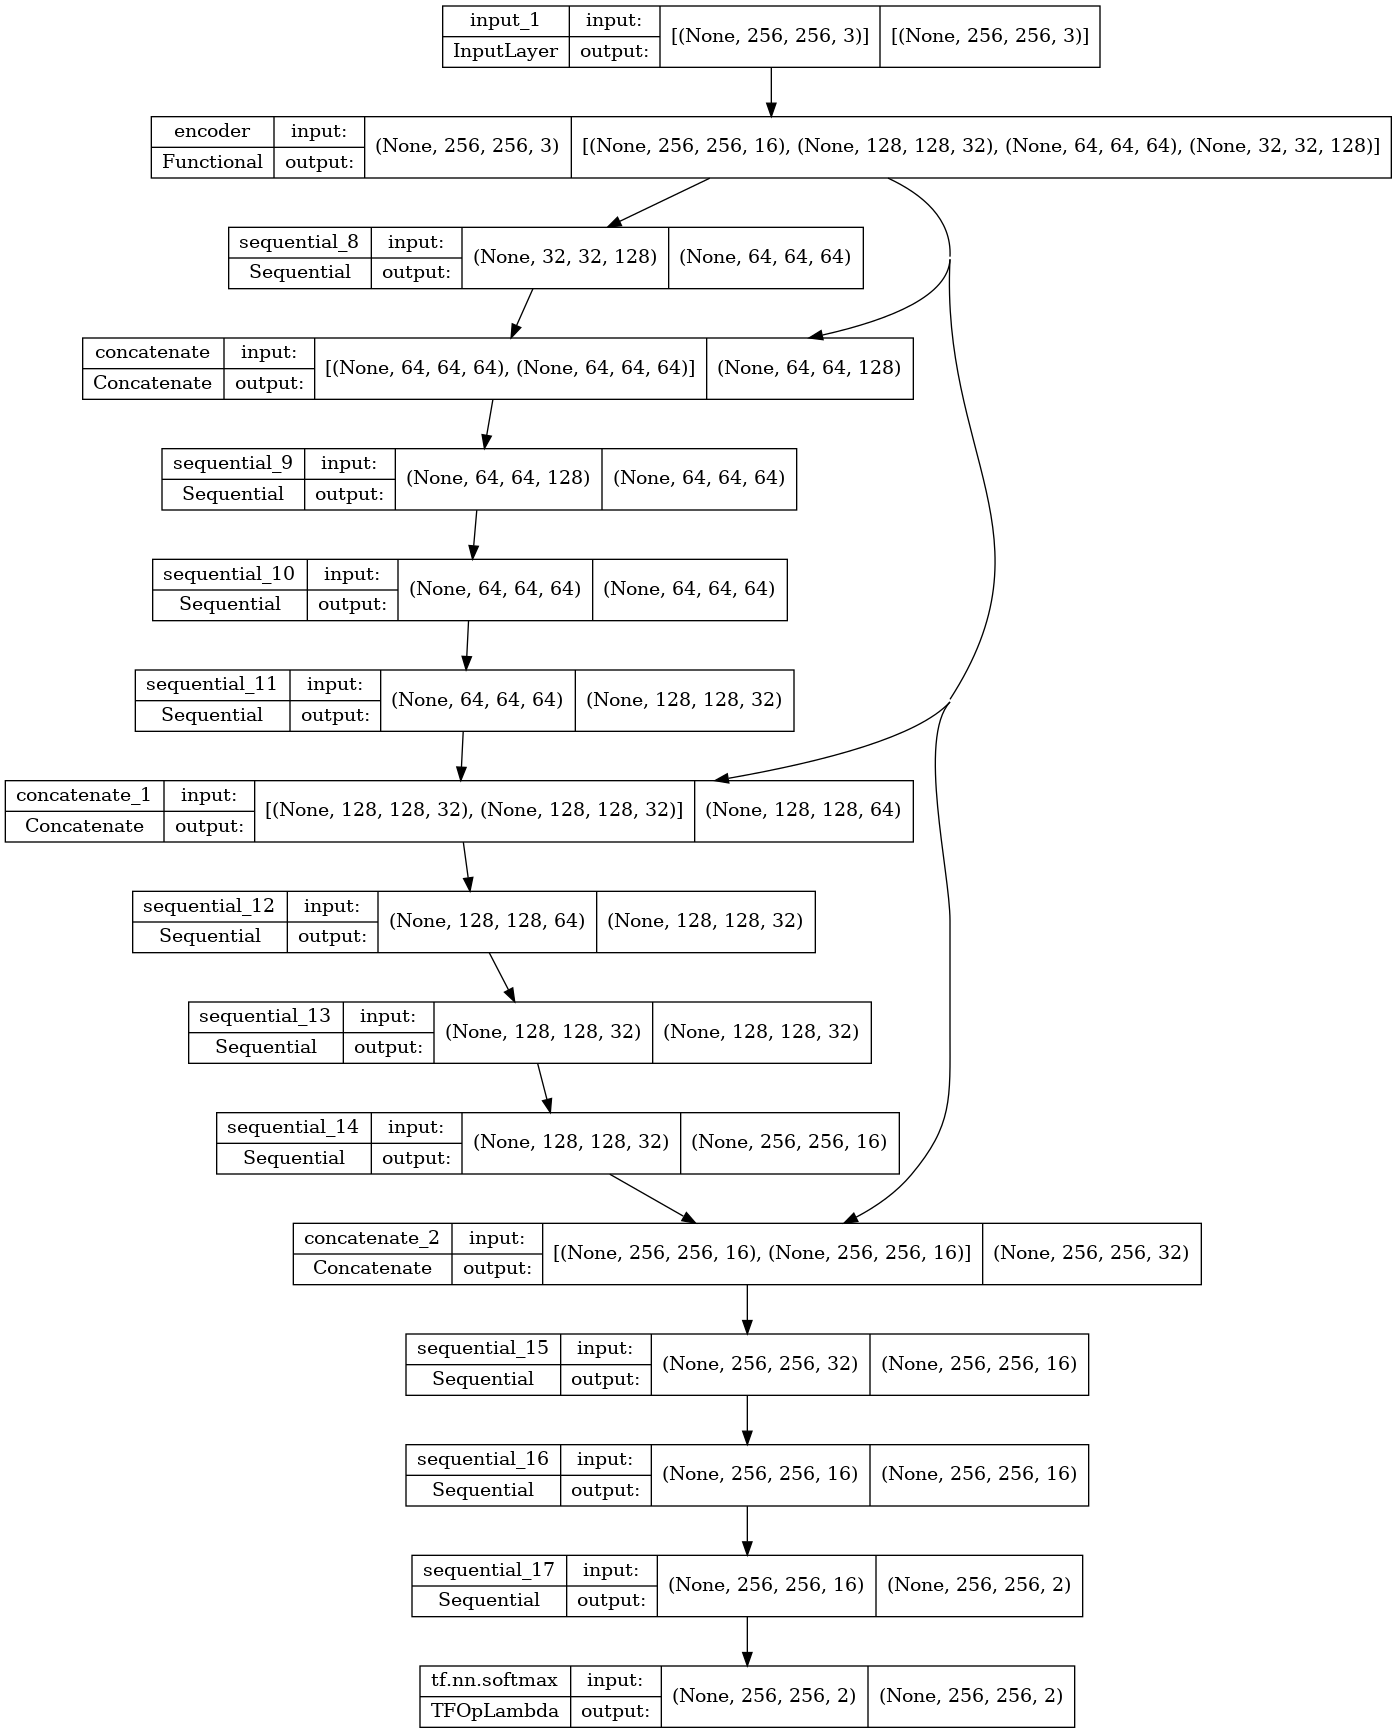

In [4]:
# Calculate the number of steps per epoch for training
STEPS_PER_EPOCH = Utils.calculate_train_length(images_list, Constants.VALIDATION_LENGTH,
                                               Constants.TEST_LENGTH) // Constants.BATCH_SIZE

# Define the optimizer using RectifiedAdam with Lookahead
optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=0.005,
    total_steps=Constants.EPOCHS * STEPS_PER_EPOCH,
    warmup_proportion=0.3,
    min_lr=0.00001,
)
optimizer = tfa.optimizers.Lookahead(optimizer)

# Define the loss function as CategoricalCrossentropy
loss = tf.keras.losses.CategoricalCrossentropy()

# Define the mean Intersection over Union metric
mIoU = IoU_nodule(num_classes=2, target_class_ids=[0, 1], sparse_y_true=False, sparse_y_pred=False, name='mean-IoU')

# Create a UNetModel instance and compile the model with the optimizer and loss function
model = UNetModel(Constants.IMG_SHAPE + (3,)).model
model.compile(optimizer=optimizer,
              loss=loss,  # bce_dice_loss,
              metrics=[mIoU, Metric.dice], )

# Print the number of trainable parameters in the model
trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(f'Trainable params: {trainable_params}')

# Plot the model architecture using TensorFlow's plot_model() function
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.load_weights(Constants.CHECKPOINT_FILEPATH)

In [6]:
results = model.evaluate(test_batches)
print("test loss, test mIoU:", results)

2023-03-25 23:57:40.018273: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-03-25 23:57:40.101165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-03-25 23:57:40.161143: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-03-25 23:57:40.238921: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-03-25 23:57:40.275383: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.


125/125 [==============================] - 303s 2s/step - loss: 0.0044 - mean-IoU: 0.7829 - dice: 0.9976
test loss, test mIoU: [0.004360194783657789, 0.7828999757766724, 0.997581422328949]


In [7]:

def predict(image):
    image = np.expand_dims(image, axis=0)
    pred_mask = model.predict(image)[0].argmax(axis=-1)
    return pred_mask

tf.Tensor(0.76809144, shape=(), dtype=float32)


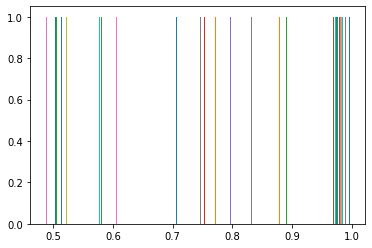

In [9]:
from matplotlib import pyplot as plt
from utils import Constants
from models.Metrics.Loss.IoU import IoU

mIoU = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=True, sparse_y_pred=True, name='mean-IoU')
IoU_results = []
for image, true_mask in test_dataset.take(2000):
    true_mask = true_mask.numpy().argmax(axis=-1)
    pred_mask = predict(image)
    mIoU.update_state(true_mask, pred_mask)

    iou = IoU(num_classes=2, target_class_ids=[0, 1], sparse_y_true=True, sparse_y_pred=True, name='mean-IoU')
    iou.update_state(true_mask, pred_mask)
    IoU_results.append(iou.result())

plt.hist(IoU_results, bins=15)
print(mIoU.result())